# DTMF Filter Design

## Goal

When bored, TamoDevBoard likes to recite digits of $\pi$.  To do this, it uses DTMF tones.  It would like to be able to decode its tones, to ensure that they match what it's sending (bored with nothing better to do, right?).

This notebook is a sketch of the design of filters to enable that reception on the ADC.  We're going to look at generating the tones first, then receiving them using massive desktop computing.  Once we know that this is working, we'll move on to algorithms that work piecewise, and finally move down into 8b hand-coded algorithms.

A lot of the heavy lifting here was done by Andrea Vitali, and published in ST Design Tip DT0089.  We owe him a huge debt for laying out such a nice technique, and hope that this notebook can help more people understand the techniques in that whitepaper.

Also, a note on the presentation style of this document: it is intended mostly for an audience of hackers with a middling (and spotty) awareness of DSP.  It's also not a particularly formal presentation, because this is a fun Open Source project, and not a core part of the argali framework itself.

## Background

Dual-tone Multi-Frequency (DTMF) is a way of encoding up to 16 digits with a bank of 8 tones.  To send a single digit, two frequencies are overlaid, which can be easily distinguished on the receiver's end

|            | 1209 Hz | 1336 Hz | 1477 Hz | 1633 Hz |
|------------|---------|---------|---------|---------|
| **697 Hz** |     1   |      2  |     3   |     A   |
| **770 Hz** |     4   |      5  |     6   |     B   |
| **852 Hz** |     7   |      8  |     9   |     C   |
| **941 Hz** |     *   |      0  |     #   |     D   |

You may recognize this layout from the screen that pops up when you send a text message to someone who isn't in your contact list.  Though, there is the addition of "A", "B", "C", and "D", which may even surprise people old enough to remember when that layout was an array of physical buttons.

So, to generate a "1" digit, we sum together two sine waves: one at 697Hz, and another at 1209Hz.  This is pretty straightforward.

For receiving, we'll first use trivial FFTs, as they're easy enough to do.  Then we will implement the Goertzel algorithm, which is a bit more amenable to being run on a microcontroller.

## External References

There are telecoms standards for this, but they cost money and, well, we're not actually attaching this to a phone line, so.

The wikipedia article, [Dual-tone multi-frequencysignaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling), is actually pretty great, and it seems to be available in lots of languages.

## Results

We have the following in hand:

* A good, if challenging to understand, implementation of DTMF decoding using eight IIR filters (second-order, nice and tight), that works even if you don't know where the digits are supposed to be
* A formula for creating those filter coefficients
* An understanding of how to set the threshold:
    * $2/\sqrt{N}$, if you use normalized magnitudes
    * $4\sqrt{N}$ if you use raw accumulated magnitudes
* Very nice python DTMF generation
* Very easy python DTMF decoding

## Next Steps

* Export data for test cases in the C implementation

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15,5)

Populating the interactive namespace from numpy and matplotlib


# Generation: Easy Mode

First up, generating the signals.  This is straightforward in easy mode: we simply create a buffer long enough to fit the entire transmission, fill it in.  No state between calls, etc, just a simple one-and-done.  We need a bit of knowledge beyond the string of digits, though.  Firstly, how long each digit should last, and how long to leave between them.  This tells us how long the buffer is, and where to "paint in" our tones along that line.  If we're given the number `159` and the durations as 2 seconds on, 1 second off, we know that we need to do the following:

* Create a buffer that can hold `len("159") * (2 + 1)` = 9 seconds of audio
* In that buffer, fill in the span from 0-2 seconds with 697Hz and 1209Hz.
* Then, skip to `2+1` = 3 seconds in, and add 2 seconds of 770Hz and 1336Hz
* Finally, go to `2*3` = 6 seconds in, and add 2 seconds of 852Hz and 1477Hz

But, of course, this is a computer, so we have to work in discrete time.  Thus we need to know our sampling rate, $F_s$.  This is how many samples are taken per second; 8kHz is a good option here.

Combining all of this, our function signature here is `dial(Fs, digit_dur, gap_dur, number) -> buffer`, along with an implicit copy of the tones table seen above.  We'll implement that now.

In [2]:
class DTMFGen:
    '''A DTMF Generator container class'''
    
    # A mapping of character to tones
    TONES = {
        '1': (697,1209),
        '4': (770,1209),
        '7': (852,1209),
        '*': (941,1209), 
        
        '2': (697,1336),
        '5': (770,1336),
        '8': (852,1336),
        '0': (941,1336),
        
        '3': (697,1477),
        '6': (770,1477),
        '9': (852,1477),
        '#': (941,1477),
        
        'A': (697,1633),
        'B': (770,1633),
        'C': (852,1633),
        'D': (941,1633),    
    }
    
    @classmethod
    def dial(cls, Fs: float, digit_dur: float, gap_dur: float, number: str):
        '''Generates a DTMF sequence for the given number
        
        Fs: the sampling rate (must be >2*1633Hz, 8kHz recommended)
        tone_dur: the duration of each digit
        gap_dur: the duration of "dead air" between digits
        number: a string of characters to map
        
        Raises KeyError if you ask for a non-DTMF character
        
        Returns an np.array() containing your dial, with a gap_dur tail.
        
        As a quick refresher on DSP basics, the value at index i of a
        tone of frequency f, sampled at Fs, will be:
        
        x[i] = sin(2*pi*f/Fs*i)
        
        We're just injecting a bunch of these into the appropriate places.
        '''
        
        spdig = int(Fs*digit_dur)  # Samples per digit
        spsym = int(Fs*gap_dur) + spdig # Samples per symbol
        
        result = np.zeros(spsym*len(number))
        
        # Note that there is some rounding in the above, which can add up
        # over very long timespans.  Specifically, we might wind up nearly
        # two samples short each symbol.  This is a very small percent error,
        # but they do accumulate.
        
        for i,c in enumerate(number):
            if c not in cls.TONES:
                raise KeyError(f'Not found on a touchtone: "{c}"')
            i0 = i*spsym
            
            # For each tone, add it on top of what's there
            for f_tone in cls.TONES[c]:
                result[i0:i0+spdig] += np.sin(2*np.pi*f_tone/Fs * np.arange(spdig))/2
            
        return np.array(result)

Let's check that these are working as expected by looking at a spectrogram of each entry.

Note that we need to add some noise to this.  That noise serves two purposes, both of which are more about presentation than functionality.

Firstly, it covers up a bunch of totally dead air gaps between symbols.  These tend to "blow out" the color mapping, and are distracting.  This is purely a presentation thing, but it's sufficient to motivate adding the noise.

Secondly, and a bit more subtly, it helps to mask some "key click."  Basically, the tones we're using don't end at zero, but instead just stop transmitting suddenly.  That very sharp edge creates wideband noise, which looks like a vertical line in the spectrogram.  Adding noise will (randomly) create smaller jumps there, as well as creating lots of other random jumps.  This results in the speckled background, and, more importantly, spreads out the energy, so you don't get nearly the same amplitude of "click" every time a digit stops.

So, we'll generate a bunch of digits, the plot them in a spectrogram.  We also throw some lines up on that spectrogram of where we expect the digits to be, along with what digit was generated in that span

In [3]:
from typing import Tuple, List

# To help visualize our results, we'll doodle on the spectrogram
def annotate_spectrogram_arr(Fs: float, entries: List[Tuple[str,float,float]]) -> None:
    '''A janky helper to plot expected results on a spectrogram 
    
    This will drop dashed lines where we expect to see tones, and
    write out which symbol is in each time band
    '''    
    for sym, t0, dt in entries:
        t1 = t0 + dt
        text(t0+0.2*dt, 200, sym, weight='bold', color='white', fontsize='x-large')
        
        f0,f1 = DTMFGen.TONES[sym]

        plot([t0,t1], [f0,f0], '--', color="blue")
        plot([t0,t1], [f1,f1], '--', color="red")
        
def annotate_spectrogram(Fs: float, digit_dur:float , gap_dur:float, s: str) -> None:
    '''An easier version of the annotation, for places where we have known-location data'''
    sym_dur = digit_dur + gap_dur

    arr = [ (c, sym_dur*i, digit_dur) for i,c in enumerate(s) ]
    return annotate_spectrogram_arr(Fs, arr)

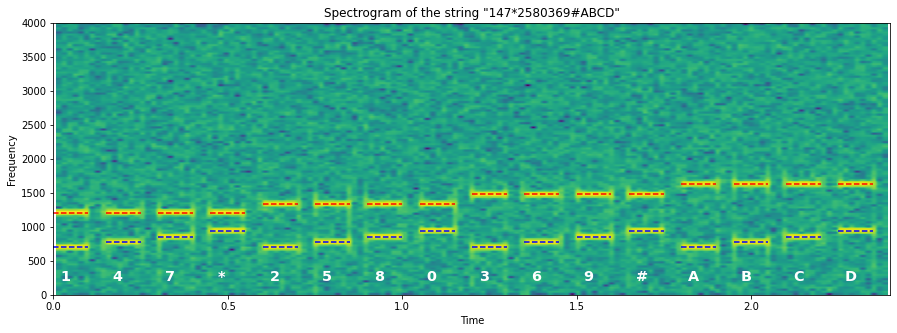

In [4]:
Fs = 8000
digit_dur = 0.1
gap_dur = 0.05

s = '147*2580369#ABCD'

tones = DTMFGen.dial(Fs, digit_dur, gap_dur, s)

# Add some noise to mask gaps, tweak the coefficient and see how it changes
tones += 2*np.random.uniform(-0.1, 0.1, len(tones))

# Plot the spectrogram
specgram(tones, Fs=Fs)

# And some labels because always label your axes
title(f'Spectrogram of the string "{s}"')
xlabel("Time")
ylabel("Frequency")

# And doodle on it to see expected results
annotate_spectrogram(Fs, digit_dur, gap_dur, s)

sym_dur = digit_dur+gap_dur
xlim(0,sym_dur*len(s)); # the annotations sometimes bump this

# Decoding: Easy Mode

Okay, that wasn't too bad.  Now, let's do a quick decoder, also in easy mode.

In this case, we take in the full buffer, and know where we expect to find digits.  This lets us slice and dice the input buffer into digit timeslices.  In each timeslice, we just need to find which two tones are the strongest, and decode based on that.

This is pretty straightforward, with a few practical wrinkles to address.

Firstly, our tones are separated by about 75Hz in the lower end, and ~140Hz in the higher end.  This means that our minimum bucket size should be less half that, or about 30Hz.  This puts a lower limit on the number of buckets we need: `Fs/30`.  Similarly, the digit duration will only be so many samples long: `Fs*digit_dur`.  In general, these are not particularly onerous bounds. 

The next consideration is that FFTs really prefer to work on powers of two.  So, we'll try to get there by simply finding the power of two below our maximum number of bins.  This should still give us narrow enough bins to distinguish our tones.

Finally, we must acknowledge how brittle this technique is.  A misalignment in time, or frequency drift (which could be as exciting as doppler shift from a satellite or as boring as clock drift due to temperature changes) will both break this system.  More importantly, they will break it in a way that leaves absolutely no trace.  This decoder will happily try to decode pure noise as input.

All that said, here's the outline of this process:

* Compute max NFFTs by `Fs*digit_dur`
* Reduce that down to the next lowest power of two, call it `nffts`
* For each of the 8 tones, find which bucket they fall into
* Determine the length of the array in digits
* For each of those digit locations
    * Extract `nffts` samples and FFT it
    * Find the maximum "low" tone (row labels in the first table)
    * Find the maximum "high" tone (column labels in the first table)
    * Decode that to a digit and append it to the result
    
This is implemented reasonably quickly:

In [5]:
class DTMFDecoder:
    TONES_LOW = [ 697,770, 852, 941 ]
    TONES_HIGH = [1209, 1336, 1477, 1633]
    
    TONE_MAP = [ # low,high indexed array of "arrays"
        "123A",
        "456B",
        "789C",
        "*0#D"
    ]

    @classmethod
    def decode_buf(cls, Fs: float, digit_dur: float, gap_dur: float, buf: np.array) -> str:
        result = "" # Accumulator
        
        # Compute max FFTs
        symbol_len = int(Fs * (digit_dur + gap_dur))
        
        # Find the closest power of 2, as that's how FFTs generally work
        max_ffts = digit_dur*Fs
        nffts = 2**int(np.log2(max_ffts))
        
        # Map our tones into bin numbers
        binsize = Fs/nffts # How many Hz each bin crosses
        
        if binsize > 30:
            raise ValueError(f'Bins span {binsize:0.1f}Hz, but we want 30Hz maximum.')
             
        bins_low = (np.array(cls.TONES_LOW) / binsize).astype(np.int)
        bins_high = (np.array(cls.TONES_HIGH) / binsize).astype(np.int)
        
        # Determine the length of the array in digits
        n_symbols = len(buf) // symbol_len

        # For each digit location:
        for i in range(0, n_symbols):
            # Run the FFT
            i0 = symbol_len * i
            vals = np.abs(np.fft.rfft(buf[i0:i0+nffts]))
            
            # Find the maximum low and high tone
            n_low = np.argmax(vals[bins_low])
            n_high = np.argmax(vals[bins_high])
            
            # And decode it
            result += cls.TONE_MAP[n_low][n_high]
        
        return result
        
        
DTMFDecoder.decode_buf(Fs, digit_dur, gap_dur, tones)

'147*2580369#ABCD'

# Decoder: hard mode

Next, we'll do a windowed decoder.  This is where we only get a small window of samples, and have to figure out what's going on from that.  This is a reasonably close match to our intended application environment.

Conveniently enough, there is an ST datasheet containing exactly this: DT0089 Rev 1.  It was written by Andrea Vitali, who does a great job of presenting things thoroughly (though he does so within the limitations placed upon him).  I'll "replay" his derivation here, as I find properly-formatted math much easier to follow than math written in Word.  That said, this won't reach too far into the basics.  Those would take more than weekend to catch up on, so I'm not going to try and cram too much in here.  That said, they're definitely worth the time investment if you find this kind of thing interesting.  If you have *any* calculus background, a great place to start is the [Fourier transform introduction video from 3Blue1Brown on YouTube](https://www.youtube.com/watch?v=spUNpyF58BY).

The salient fact from Vitali's implementation is this: it works at 4kHz 8b samples, on 200 sample long buffers.  This is not surprising, as it's from an ST report, but, still.  This will work for us, if we can get it to work in the first place.  The C code is, well, it's preceded by Matlab code.  It has been said that one can write C in anything, and, this program is a lemma demonstrating that one can therefore write Matlab in anything.  Thankfully, most of this code is concerned with generating the coefficients, which we can do in python for our application.  By doing so, we avoid the overhead of a proper sine implementation in our codebase.  No, our existing one is not likely to be good enough for this application, so I won't even try.

Now that my soul has been salved, let us continue to examine the modified Goertzel algorithm in a bit more detail.  Specifically, let's project it into LaTeX here, so we can actually see the equations.

## DFT review

Firstly, we refresh our memory of the DFT:
$$
% This is a latex comment.
% The dollardollar implentation in jupyter HATES empty lines, so don't leave any in your document.
\begin{eqnarray}
N &&  &-& \text{The number of samples in the input array} \\
x(n) &&  &-& \text{The input array} \\
W(t) &=& \exp\left(-j 2 \pi \frac{t}{N}\right) &-& \text{The usual discrete-time complex exponential} \\
y(k) &=& \sum_n^N{W(nk)x(n)}, k \in [0,1,\ldots,N-1] &-& \text{DFT, as usual, except $y$ instead of $X$} \\
\end{eqnarray}
$$

We then note that $W(-Nk) = \exp\left(-j 2\pi \frac{N}{N}\right) = \exp\left(-j 2 \pi \right)= 1$, and therefore $y(k) = \sum{W(k(n-N))x(n)}$.  This only works if $W(k(n-N)) = W(kn)$.  Let's derive that, as a treat:

$$
\begin{eqnarray}
W(t)      &=& \exp\left(-j 2 \pi \frac{t}{N}\right) &-& \text{Original definition} \\
W(N)      &=& -1 &-& \text{As mentioned in last paragraph} \\
W(k(n-N)) &=& \exp\left(-j 2 \pi \frac{k(n-N)}{N}\right) &-& \text{Modified from the guts of $y(k)$} \\
          &=& \exp\left(-j 2 \pi \frac{kn-kN)}{N}\right)  \\
          &=& \exp\left(-j 2 \pi \left(\frac{kn}{N}-N\right)\right) \\
          &=& \exp\left(-j 2 \pi \frac{kn}{N} + j 2 \pi N\right) &-& \text{Multiply the $-j 2 \pi$ through}\\
          &=& \exp\left(-j 2 \pi \frac{kn}{N}\right) \exp\left( j 2 \pi N\right) &-& \text{Exponent rules}\\
          &=& W(nk) \exp\left( j 2 \pi N\right) &-& \text{Going back to definition of $W(nk)$} \\
          &=& W(nk) \cdot 1 &-& \text{Complex exponentials ($e^{2\pi N} = 1$)} \\
\end{eqnarray}
$$


## Turning the DFT into an IIR: the setup
Vitali then expands out the summation in $y(k)$, and notes a recursive structure in it.  The trick here is that $W(-2k)= W(-k)W(-k)$.  This works out, because W is just a wrapper around an exponential with $k$ as a pure numerator, and addition inside the exponential is multiplication outside.

We can therefore gradually factor a $W(-k)$ out of every term in the summation, and replace 
$$
W(-k)x(N-1) + W(-2k)x(N-2) + W(-3k)x(N-3) + \ldots
$$

with

$$
W(-k) \cdot \left( x(N-1) + W(-k)x(N-2) + W(-2k)x(N-3) + \ldots\right)
$$

As this is a nice recursion, we can split it out into an algorithm that computes it in N steps, using a new formula $y_n(k)$ formula that is a refactoring of the original $y(k)$.  Mathematicians do this kind of name aliasing thing all the time.  At least he indexes from zero.

$$
\begin{eqnarray}
y_n(k) &=& W(-k)\left(x(n) + y_{n-1}(k) \right) &-& \text{$n$ going from $0$ to $N-1$} \\
y_0(k) &=& 0 &-& \text{Base case to end recursion}  \\
    y(k) &=& y_{n-1}(k) &-& \text{Our original $y(k)$ is now $y_{n-1}(k)$. Mathematicians!}
\end{eqnarray}
$$

## Turning the DFT into an IIR: the payoff


This can be turned into an IIR that lets us work with non-complex values until the final step.  Sorry, wait: if you need an intro to digital filters, [Phil's Lab has a great YouTube video on IIR filters](https://www.youtube.com/watch?v=QRMe02kzVkA), which includes a backgrounder on filters as well.

Okay, we can turn this formula into an IIR filter by projecting through the z-domain.  $Y(z) = W(-k)\left(X(z)+Y(z)z^{-1}\right)$, making the transfer function a nice, neat $H(z) = Y(z)/X(z)$ (NB: there seems to be a typo of $X(x)$ in the original, corrected here).

We'll do a couple of identities involving $W(k)$ first, which will make life a lot easier in a second.  You can skip these if you don't really care, or skip them for now, coming back when you need them in the derivation of $H(z)$ below.

First up, a multiplicative identity, $W(-k)W(+k)$:

$$
\begin{eqnarray}
W(-k)W(+k) &=& \exp\left(j 2 \pi \frac{k}{N}\right)\exp\left(-j 2 \pi \frac{k}{N}\right) &-& \text{From definition} \\
           &=& \exp(0) &-& \text{Exponent rule: add the exponents, which cancel each other out}\\
W(-k)W(+k) &=& 1       &-& \text{A convenient result.} \\
\end{eqnarray}
$$

Pleasingly, the other identity we need is an additive one: $W(-k) + W(+k)$:

$$
\begin{eqnarray}
W(-k)+W(+k) &=& \exp\left(\left(j 2 \pi \frac{k}{N}\right)+\exp\left(-j 2 \pi \frac{k}{N}\right)\right) &-& \text{From definition}\\
            &=& \exp\left(\left(j 2 \pi \frac{k}{N}\right)\left(-j 2 \pi \frac{k}{N}\right)\right) &-& \text{Exponent rule: addition becomes multiplication}\\
            &=& \exp\left(-\left(j 2\pi\frac{k}{N}\right)^2\right) &-& \text{Collect terms}\\
            &=& 2 \exp\left(-j 2 \pi \frac{k}{N}\right) &-& \text{Exponent rule: exponents become multiplication} \\
            &=& 2 \exp\left(-j2\pi\frac{k}{N}\right) &-& \text{Exponent rule: exponents become multiplication} \\
W(-k)+W(+k) &=& 2 \cos\left(2\pi\frac{k}{N}\right) &-& \text{Extract the real part, and $\cos$ is even, so drop the minus}\\
\end{eqnarray}
$$

And finally, we can work on $H(z)$:
$$
\begin{eqnarray}
H(z) &=& Y(z)                    / X(z) &-& \text{Transfer function (NB: typo of $X(x)$ in original corrected)} \\        &=& W(-k) (X(z)+Y(z)z^{-1}) / X(z) &-& \text{Substitute in for $Y(z)$} \\
     &=& W(-k)/(1-W(-k)z^{-1})          &-& \text{Divide through} \\
     &=& \frac{W(-k)}{(1-W(-k)z^{-1})}\frac{1-W(+k)z^{-1}}{1-W(+k)z^{-1}} &-& \text{multiply through by 1} \\
     &=& \frac{W(-k)-W(-k)W(+k)z^{-1}}{1-(W(-k)+W(+k))z^{-1} + W(-k)W(+k)z^{-2}} &-& \text{Expand terms} \\
H(z) &=& \frac{W(-k)+z^{-1}}{1-2\cos\left(2 \pi \frac{k}{N}\right)z^{-1}+z^{-2}} &-& \text{Apply identities we derived above} \\
\end{eqnarray}
$$

This can then be shoved into a standard form ("Direct II Form") to represent the data flow in a second-order IIR filter.  This is pretty neat, since we just need a single $W(-k)$ value and a single $2cos\left(2\pi \frac{k}{N}\right)$ value, and we can roll from there.


Now to look into that $k$ a little more.  If you've got a signals background, it's just the per-sample angular phase shift in the tone of interest at the sampling rate, or $f_{tone}/F_s$.  So, $k = f_c/F_s$ in more conventional variables.  You can now skip to "Implementing the DFT IIR" below this.

For everyone else, a quick jump back into arguably the most confusing part of basic DSP: angular velocity in discrete time.

### A quick aside: generating sine waves with samples

This section is included because there's a lot of `1/foo` involved in figuring out how to generate a given tone in a sampled system.  This confuses a lot of people, including myself if I forgot to eat lunch or am up past my bedtime, so don't feel bad if you're left scratching your head.

Let's say we want to make a tone of 10Hz at a sampling rate of 200Hz.  So, to get a full second of signal, we need 200 samples.  In that one second, a 10Hz wave would make 10 cycles, this is what Hz means.  That second is 200 samples long in our system, so each 10Hz wave is 200/10 = 20 samples long.  Let's eyeball that to make sure:

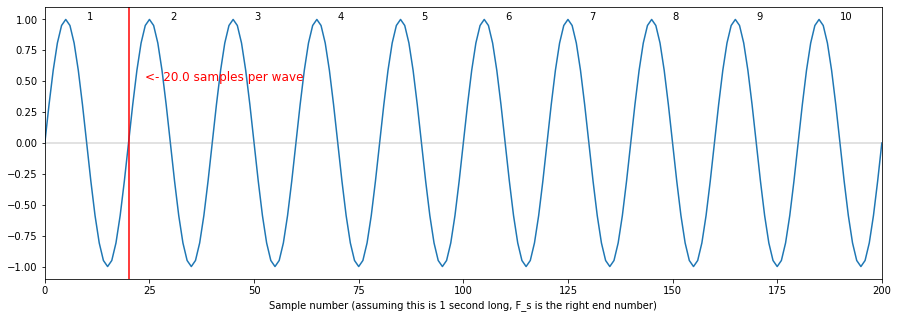

In [6]:
def sgen_example():
    '''Making this a function to keep namespaces clean'''
    Fs = 200     # Our sampling rate, in Hz
    f_tone = 10  # The tone we want to generate

    t = np.arange(Fs+1)  # We cheat and go one sample over, to make it pretty
    
    y = np.sin(2*np.pi*f_tone/Fs * t) # Compute sine for all our t values
    
    # And now we plot it, and doodle on it
    plot(t,y)
    axhline(0, color="grey", alpha=0.3)
    
    samples_per_wave = Fs/f_tone
    
    axvline(samples_per_wave, color="red")
    text(samples_per_wave*1.2, 0.5, f'<- {samples_per_wave} samples per wave', color="red", size="large")
    
    for i in range(f_tone):
        text(i*samples_per_wave+samples_per_wave//2, 1.0, f'{i+1}')
    xlabel("Sample number (assuming this is 1 second long, F_s is the right end number)")
    xlim(0,Fs)
    
sgen_example()

So, every `Fs/f_tone` samples, we have a complete sine wave.  For `sin` to make a complete cycle, its input needs to go from 0° to 360°.  Of course, this is all done in radians, so it's `0` to `2*pi`.  We're going from `0` to `2*pi` in `Fs/f_tone` steps.  How big is the step between each sample, to make that happen?

Clearly, it's just `(2*pi-0)/(Fs/f_tone)`, which we can simplify a bit.  We'll drop the zero, and division by a fraction is the same as multiplying by that fraction flipped over.  So, we get `2*pi*f_tone/Fs`.

The input to `sin` is an angle, so this is actually our "angular frequency" (you'll often see it in math as $\omega$ and code as `w`, because it looks kinda like $\omega$).  Basically, if you have a sine wave of frequency $f$, its angular velocity is $2\pi f$, which means that it goes through $2\pi$ radians every $1/f$ seconds.

So, a tone of frequency `f_tone` has an angular velocity of `2 * pi * f_tone` radians/sec.  Then, if we sample it at the frequency `Fs`, each sample step is `1/Fs` seconds.  Thus, the change in angle per sample of `f_tone` is `2*pi*f_tone * 1/Fs`.

This per-sample angular change is the $k$ in our equations above.  This means that our $k$ value depends on the tone frequency we want to pull out of the signal.

## Implementing the DFT IIR

TODO: Bridge the gap from the filter design to this

Basically, you just need a couple of registers, and the coefficient for your frequency of interest (at your sampling rate):

```
# Set up our constants

w = 2*pi*f_tone/Fs # Angular velocity per sample, aka k
cos_w = cos(w)
sin_w = sin(w)

# And the registers for the filter state
z2 = z1 = 0  # Initial state

# Then run the filter
for x in samples:
    z0 = x + 2*cos_w*z1 - z2
    z2 = z1
    z1 = z0

# And then compute our output at the end of the buffer
res_i = z0 * cos_w - z1
res_q = z0 * sin_w
        
# And here's the strength of the signal of interest:
res_mag = math.sqrt(res_i*res_i + res_q*res_q)
```

And that's it.  Let's actually run this thing.  We'll do two of them: one with a matching frequency, and one with an unrelated frequency, to see what happens when there's irrelevant signal present.

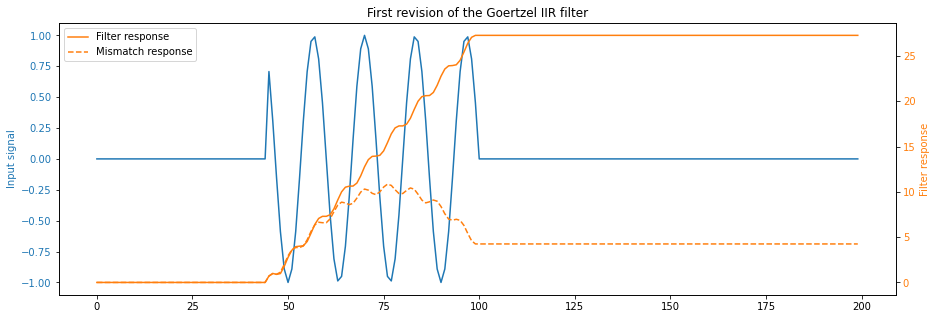

In [25]:
import math  # Going with "bare-metal" python to ease C translation

from typing import List  # And let's type things, why not?

def one_tone_goertzel_v0(Fs: float, f_tone: float, samples: List[int]) -> List[float]:
    '''Get the *accumulated* magnitude of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    
    Returns a list of floats, coindexed to the samples, of the magnitude of the
    filter response to the input.
    
    In practice, you probably just want to run the z0 loop, and only run the
    res_i,res_q computations periodically.
    
    Also, note that the sqrt is totally unnecessary, but is pedantically correct.
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
    
    result = [0.0] * N  # We'll save the magnitude of our results
    
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = x + 2*cos_w * z1 - z2
        
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        res_i = z0 * cos_w - z1
        res_q = z0 * sin_w
        
        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        result[i] = res_mag
        
        # You can get phase here, too, just look at
        # phase = math.atan2(res_q, res_i)
        # However it's not clear to me how to interpret it, as
        # it wiggles even after your tone stops.
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
    return result
 
def one_tone_demo_v0():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    Fs = 200
    f_tone = 15
    signal = [0] * 200
    
    for i in range(45,100):
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
    
    goertzel_response = one_tone_goertzel_v0(Fs, f_tone, signal)
    goertzel_response_mismatch = one_tone_goertzel_v0(Fs, f_tone*1.21, signal)
    
    # Gonna do dual axes for legibility
    fig, ax1 = plt.subplots() 
    ax2 = ax1.twinx()
    
    ax1.plot(signal, label='Input signal', color='tab:blue')
    ax1.tick_params(axis ='y', labelcolor = 'tab:blue') 
    ax1.set_ylabel('Input signal', color='tab:blue')
    
    ax2.plot(goertzel_response, label='Filter response', color='tab:orange')
    ax2.plot(goertzel_response_mismatch, '--', label='Mismatch response', color='tab:orange')
    legend()
    ax2.tick_params(axis ='y', labelcolor = 'tab:orange') 
    ax2.set_ylabel('Filter response', color='tab:orange')

    xlabel('Sample number')
    title('First revision of the Goertzel IIR filter')
    
one_tone_demo_v0()

This is promising, though it's unfortunate that our mismatched filter actually catches some energy.

Beyond that, it's clear that we have a problem here: the filter response seems to grow without bound, and doesn't have much of a falling off.  What if we added a decay term that fell off over some number of cycles?  Looking at our equations, this should be as simple as adding an $\alpha$ term to the `z0` computation.  Let's try that.

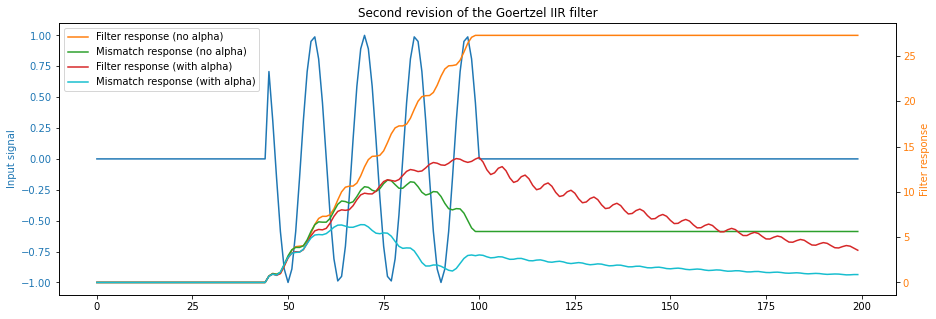

In [8]:
import math  # Going with "bare-metal" python to ease C translation

from typing import List  # And let's type things, why not?

def one_tone_goertzel_v1(Fs: float, f_tone: float, samples: List[int], alpha=1.0) -> List[float]:
    '''Get the *accumulated* magnitude of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    alpha: the decay value, which allows filters to die off when they are no longer stimulated
    
    Returns a list of floats, coindexed to the samples, of the magnitude of the
    filter response to the input.
    
    In practice, you probably just want to run the z0 loop, and only run the
    res_i,res_q computations periodically.
    
    Also, note that the sqrt is totally unnecessary, but is pedantically correct.
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
    
    result = [0.0] * N  # We'll the magnitude of our results
    
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = alpha*(x + 2*cos_w * z1 - z2) - (1-alpha)*z1
        
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        res_i = z0 * cos_w - z1
        res_q = z0 * sin_w
        
        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        result[i] = res_mag
        
        # You can get phase here, too, just look at
        # phase = math.atan2(res_q, res_i)
        # However it's not clear to me how to interpret it
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
    return result
 
def one_tone_demo_v1():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    Fs = 200
    f_tone = 15
    signal = [0] * 200
    
    for i in range(45,100):
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
    
    
    # Let's shoot for a few cycles
    alpha = 1-1.0/(3*Fs/f_tone)
    
    goertzel_response_base = one_tone_goertzel_v1(Fs, f_tone, signal)
    goertzel_response_alpha = one_tone_goertzel_v1(Fs, f_tone, signal, alpha)
    
    goertzel_response_mismatch = one_tone_goertzel_v1(Fs, f_tone*1.2, signal)
    goertzel_response_mismatch_alpha = one_tone_goertzel_v1(Fs, f_tone*1.2, signal, alpha)

    
    # Gonna do dual axes for legibility
    fig, ax1 = plt.subplots() 
    ax2 = ax1.twinx()
    
    ax1.plot(signal, label='Input signal', color='tab:blue')
    ax1.tick_params(axis ='y', labelcolor = 'tab:blue') 
    ax1.set_ylabel('Input signal', color='tab:blue')
    
    ax2.plot(goertzel_response_base, label='Filter response (no alpha)', color='tab:orange')
    ax2.plot(goertzel_response_mismatch, label='Mismatch response (no alpha)', color='tab:green')
    
    ax2.plot(goertzel_response_alpha, label='Filter response (with alpha)', color='tab:red')
    ax2.plot(goertzel_response_mismatch_alpha, label='Mismatch response (with alpha)', color='tab:cyan')

    legend()
    
    ax2.tick_params(axis ='y', labelcolor = 'tab:orange') 
    ax2.set_ylabel('Filter response', color='tab:orange')

    xlabel('Sample number')
    title('Second revision of the Goertzel IIR filter')
    
one_tone_demo_v1()

This seems like an improvement.  One important note here: the alpha will be frequency-dependent if you want it to depend on the number of cycles.  Bear that in mind, or do it based on time instead of cycles.

Let's add some noise, and see how it deals with that.  We'll also add signal clipping, to be particularly mean to it.

###### import math  # Going with "bare-metal" python to ease C translation
import random  # Come on feel the noise

from typing import List  # And let's type things, why not?

def one_tone_goertzel_v1(Fs: float, f_tone: float, samples: List[int], alpha=1.0) -> List[float]:
    '''Get the *accumulated* magnitude of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    alpha: the decay value, which allows filters to die off when they are no longer stimulated
    
    Returns a list of floats, coindexed to the samples, of the magnitude of the
    filter response to the input.
    
    In practice, you probably just want to run the z0 loop, and only run the
    res_i,res_q computations periodically.
    
    Also, note that the sqrt is totally unnecessary, but is pedantically correct.
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
    
    result = [0.0] * N  # We'll the magnitude of our results
    
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = alpha*(x + 2*cos_w * z1 - z2) - (1-alpha)*z1
        
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        res_i = z0 * cos_w - z1
        res_q = z0 * sin_w
        
        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        result[i] = res_mag
        
        # You can get phase here, too, just look at
        # phase = math.atan2(res_q, res_i)
        # However it's not clear to me how to interpret it
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
    return result
 
def one_tone_demo_v1_noise():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    Fs = 200
    f_tone = 15
    
    noise_amp = 0.5

    signal = [ noise_amp*(2*random.random()-1.0) for _ in range(200) ]
    
    
    for i in range(45,100):
        signal[i] += math.sin(2*math.pi*f_tone/Fs*i)
        
    # And add clipping, to see what happens
    for i in range(len(signal)):
        if signal[i] < -1:
            signal[i] = -1
        if signal[i] > 1:
            signal[i] = 1
    
    # Let's shoot for a few cycles
    alpha = 1-1.0/(3*Fs/f_tone)
    
    goertzel_response_base = one_tone_goertzel_v1(Fs, f_tone, signal)
    goertzel_response_alpha = one_tone_goertzel_v1(Fs, f_tone, signal, alpha)
    
    goertzel_response_mismatch = one_tone_goertzel_v1(Fs, f_tone*1.2, signal)
    goertzel_response_mismatch_alpha = one_tone_goertzel_v1(Fs, f_tone*1.2, signal, alpha)

    
    figure(figsize=(15,10))
    subplot(2,1,1)
    # Gonna do dual axes for legibility
    ax1 = plt.subplot(211) 
    ax2 = ax1.twinx()
    
    ax1.plot(signal, label='Input signal', color='tab:blue')
    ax1.tick_params(axis ='y', labelcolor = 'tab:blue') 
    ax1.set_ylabel('Input signal', color='tab:blue')
    
    ax2.plot(goertzel_response_base, label='Filter response (no alpha)', color='tab:orange')
    ax2.plot(goertzel_response_mismatch, label='Mismatch response (no alpha)', color='tab:green')
    
    ax2.plot(goertzel_response_alpha, label='Filter response (with alpha)', color='tab:red')
    ax2.plot(goertzel_response_mismatch_alpha, label='Mismatch response (with alpha)', color='tab:cyan')

    legend()
    
    ax2.tick_params(axis ='y', labelcolor = 'tab:orange') 
    ax2.set_ylabel('Filter response', color='tab:orange')

    xlabel('Sample number')
    title('Second revision of the Goertzel IIR filter')
    
    subplot(2,1,2)
    psd(signal, Fs=Fs)
    title('PSD of noisy signal')
    axvline(f_tone, color='red', alpha=0.3)
    
one_tone_demo_v1_noise()

I am duly impressed.  The signal is still about 10dB above the noise here, but it's dealing with it pretty well.

Let's try doing a DMTF decoder now.

## DTMF Decoder via DFT IIR

We just need to make a bank of 8 of these filters, one for each of our tones.  We then run all 8 of them on the inputs, and assess the outputs at the end of the buffer.  If we run them on small enough buffers, we can do some "smoothing" of our output button decodes, too.  But that's for later.

We'll also leave out our alpha here, since it adds complications that we can deal with by running the evaluation (and reseting our accumulator) more often.

This first version takes advantage of the fact that we know where the tones are going to be found.  We'll do a rolling version after getting this working.

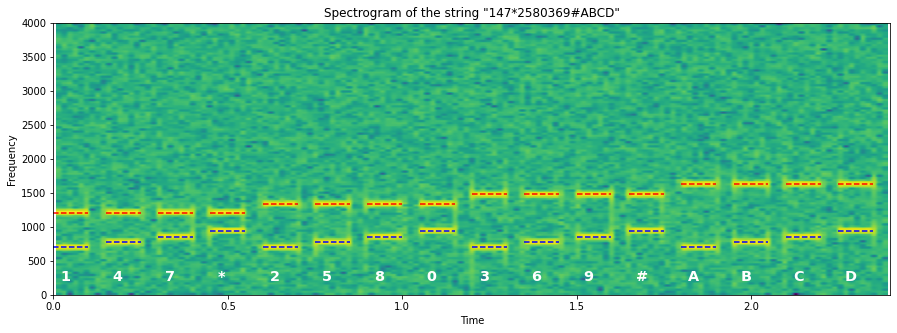

In [10]:
import math  # Going with "bare-metal" python to ease C translation
import random  # Come on feel the noise

from typing import List, Tuple  # And let's type things, why not?

def _goertzel_coeffs(Fs: float, f_tone: float):
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    return (cos_w, sin_w)

def dtmf_goertzel(Fs: float, samples: List[int]) -> Tuple[str, float]:
    '''Decodes a buffer containing a single DMTF symbol
    
    Returns a character along with the magnitude of its signal. This 
    magnitude is a function of buffer length, so treat it accordingly.
    '''
    
    TONES = [ 697,770, 852, 941,  # rows
             1209, 1336, 1477, 1633] # columns
    
    SYMBOLS = "123A456B789C*0#D"
    
    # Generate our coefficients in a bank of values
    cos_w_table = [ 0.0 ] * 8
    sin_w_table = [ 0.0 ] * 8
   
    for i in range(8):
        cos_w_table[i], sin_w_table[i] = _goertzel_coeffs(Fs, TONES[i])

    # Registers for our IIR
    z2_table = [0.0] * 8
    z1_table = [0.0] * 8
    
    # Output magnitudes
    mag_table = [0.0] * 8
    
    ###########################################
    # The actual filter
    for i in range(2, len(samples)):
        x = samples[i]
        
        for tone_no in range(8):
            z1 = z1_table[tone_no]
            z2 = z2_table[tone_no]

            ##########################
            # Run z-transform
            # Generate our new z value
            z0 = x + 2*cos_w_table[tone_no] * z1 - z2

            z2_table[tone_no] = z1_table[tone_no]
            z1_table[tone_no] = z0

    ###########################################
    # Decode the symbols
    
    mags_debug = []
    
    best_row = None
    best_row_mag = 0.0
    # Find our best row value
    for i in range(4):
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        z1 = z1_table[i]
        z2 = z2_table[i]
        
        res_i = z1 * cos_w_table[i] - z2
        res_q = z1 * sin_w_table[i]

        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        mags_debug.append(res_mag)

        if res_mag > best_row_mag:
            best_row = i
            best_row_mag = res_mag
            
    best_col = None
    best_col_mag = 0.0
    # Find our best row value
    for i in range(4,8):
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        z1 = z1_table[i]
        z2 = z2_table[i]
        
        res_i = z1 * cos_w_table[i] - z2
        res_q = z1 * sin_w_table[i]

        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        mags_debug.append(res_mag)
        if res_mag > best_col_mag:
            best_col = i
            best_col_mag = res_mag
            
    
    sym = SYMBOLS[4*best_row + best_col-4]   # om nom
    sym_mag = min(best_row_mag, best_col_mag)  # Give a pessimistic estimate
        
    return (sym, sym_mag)
 
def dtmf_demo_v0():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    
    # Directly copied from the demo at the beginning of the notebook!
    
    Fs = 8000
    digit_dur = 0.1
    gap_dur = 0.05

    s = '147*2580369#ABCD'

    tones = DTMFGen.dial(Fs, digit_dur, gap_dur, s)

    # Add some noise to mask gaps, tweak the coefficient and see how it changes
    tones += 2*np.random.uniform(-0.1, 0.1, len(tones))

    symbol_samples = int((digit_dur+gap_dur) * Fs)
    
    decode = []
    for i in range(0, len(tones), symbol_samples):
        digit_samples = int(Fs*digit_dur)
        sym,mag = dtmf_goertzel(Fs, tones[i:i+digit_samples])
        decode.append(sym)
    
    # Plot the spectrogram
    specgram(tones, Fs=Fs)

    # And some labels because always label your axes
    title(f'Spectrogram of the string "{s}"')
    xlabel("Time")
    ylabel("Frequency")

    # And doodle on it to see expected results
    annotate_spectrogram(Fs, digit_dur, gap_dur, decode)

    sym_dur = digit_dur+gap_dur
    xlim(0,sym_dur*len(s)); # the annotations sometimes bump this
dtmf_demo_v0()

That actually worked the first time out.  There were a couple of stupid typos, including one in my decode string, but: it actually worked without touching anything but the names of things.

I'm surprised.  But delighted.

## DFT IIR: 8b sample depth

Now the question is: can we make this work with our 8b samples?  We'll let ourselves use floats internally still, but will pretend that we're getting 8b ADC inputs of our waveform.

Decode matches! "147*2580369#ABCD" decoded as "147*2580369#ABCD"


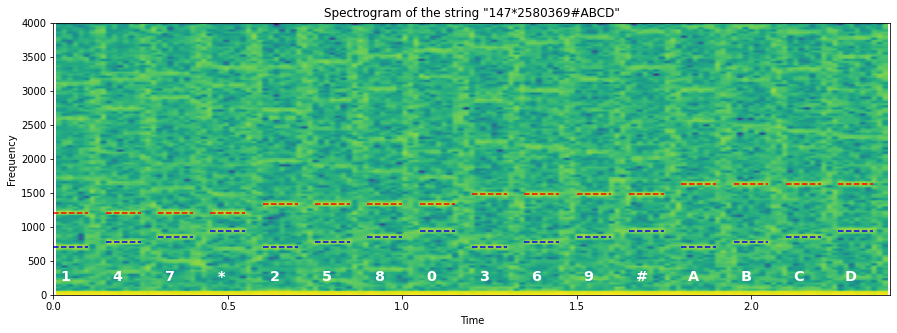

In [11]:
import math  # Going with "bare-metal" python to ease C translation
import random  # Come on feel the noise

from typing import List, Tuple  # And let's type things, why not?

 
def dtmf_demo_v1():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    
    # Directly copied from the demo at the beginning of the notebook!
    
    Fs = 8000
    digit_dur = 0.1
    gap_dur = 0.05

    s = '147*2580369#ABCD'

    tones = DTMFGen.dial(Fs, digit_dur, gap_dur, s)
    
    # Add some noise to mask gaps, tweak the coefficient and see how it changes
    tones += 2*np.random.uniform(-0.1, 0.1, len(tones))

    # And turn it into uint8s, note the limited gain
    tones = (127 + 64*tones).astype(np.uint8)

    symbol_samples = int((digit_dur+gap_dur) * Fs)
    
    decode = []
    for i in range(0, len(tones), symbol_samples):
        digit_samples = int(Fs*digit_dur)
        sym,mag = dtmf_goertzel(Fs, tones[i:i+digit_samples])
        decode.append(sym)
    
    # Plot the spectrogram
    specgram(tones-127, Fs=Fs)

    # And some labels because always label your axes
    title(f'Spectrogram of the string "{s}"')
    xlabel("Time")
    ylabel("Frequency")

    # And doodle on it to see expected results
    annotate_spectrogram(Fs, digit_dur, gap_dur, decode)

    sym_dur = digit_dur+gap_dur
    xlim(0,sym_dur*len(s)); # the annotations sometimes bump this
    
    decode_s = "".join(decode)
    does_match = "matches!" if s == decode_s else "DOES NOT MATCH:"
    
    print(f'Decode {does_match} "{s}" decoded as "{decode_s}"')
    
dtmf_demo_v1()

The results are the same!  And look at that spectrogram: it's full of nasty harmonics, but: it works.  I suspect the FPU on our uC is good enough to roll with this, and it's probably not too hard to extend it out to 16b integers.

This is pretty freaking neat, I will not lie.

## DFT IIR: 8b samples, rolling detection window

Next, we need to be able to do this without knowing the alignments ahead of time.

Eliminating that alignment requires us change the return type of our decoder.  Previously, it returned a string of symbols, and we knew how long they were at the input time.  Now, we'll return a list of `[symbol, t0, dt]` entries: the symbol received, the time offset at which it started, and how long it lasted.  In this case, `t0` and `dt` are both `float`, to keep life simple.  One could just as easily make them `int` sample counts, but it's nice to work in human units while prototyping. 

To implement this, we'll split the buffer up into a lot of little slices, and run detection on each one.  After we get back the symbol for one slice, we see if it's the same as the last slice's.  If so, we just increment the last entry's `dt`.  If it's a different symbol, we add a new `[symbol, t0, dt]` entry to our list.  This means that we actually don't know the exact length of a button press, we just know how long it was to ±1 decoding slice.  This is fine for our application, but, if you need precise timing, you will need to extend this algorithm a bit.

One more detail to discuss before getting into it: we now decode noise, and need to deal with that.  Recall that our existing algorithm just picks the strongest row tone and strongest column tone, and decodes those.  Even when it's just noise, it will decode *something*.  This has been fine before, since we only examined segments containing a symbol.  We are now going to be grabbing lots of noise, so we will want to threshold our detection.  When we get noise, we skip whatever symbol was given to us, and move on to the next sample.

Adding a "No symbol decoded" state introduces a couple of new wrinkles: if the same symbol is pressed twice in a row, we will go from `1` to `noise` to `1`.  If we don't have a way to say "The previous symbol ended with dead air," we will collapse those two `1` values into a single button press.  Similarly, if there is enough noise on the line to cause a single slice to "blip out" by falling below the magnitude threshold, we might split one symbol into two.  For now, we will only address the first problem: don't smoosh together two copies of the same symbol in a row.  The other case, where there is enough noise to break a single symbol into two, we will leave alone. 

Finally, note that this threshold value is a bit arbitrary, and we'll investigate how to set it properly a bit later.  For now, we choose a "heuristic" approac.  That is, run the algorithm with some `print` statements, eyeball it, and set a totally arbitrary threshold based on what we saw.

So, here's a sketch of our final algorithm:

* Segment the buffer into a bunch of smaller slices
* Start our accumulator list empty
* Set the force_capture flag (used to indicate the next symbol is new)
* For each slice, process it to get a `(symbol,magnitude)` tuple
* If the magnitude threshold is not met
    * Set the force_capture flag
    * Go to next slice
* (Note: magnitude threshold met is now implicitly true)
* If force_capture is unset, and the symbol matches the prior symbol
    * Extend the prior entry's `dt` by the length of the slice
    * Go to next slice
* Otherwise: (force_capture set, OR symbol doesn't match prior entry)
    * Add a new `[symbol, t0, dt]` entry to the accumulator
    * Clear force_capture
    * Go to next slice
* At the end, walk through the accumulator to get the full decoded string

For anyone not super familiar with python, `(a,b)` is a tuple, while `[a,b]` is a list.  The important difference here is that tuples are immutable, while lists can be updated in-place.  For our purposes, they are generally interchangable otherwise.

As one further aside, in an embedded implementation, we would use a callback structure instead of aggregating a full list.  The application layer would get `button_down(symbol)` and `button_up(symbol, dt)` events from the decoder.  This minimizes memory usage, and decouples the main program logic from an interrupt-driven ADC process.

Okay, all the asides are behind us now, let's implement this and see how it goes.

Decode matches! "147*2580369#ABCD" decoded as "147*2580369#ABCD"


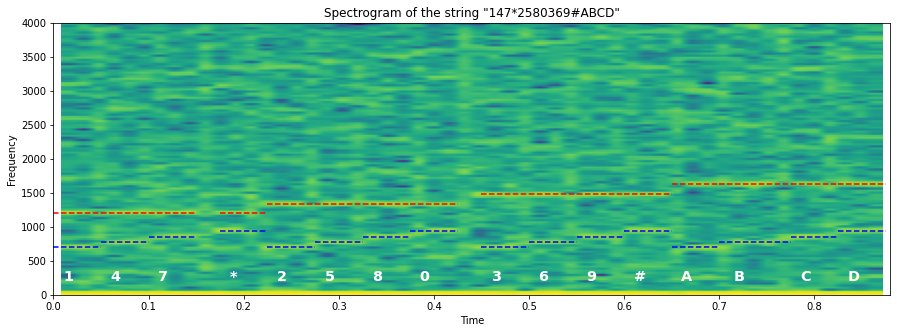

In [12]:
import math  # Going with "bare-metal" python to ease C translation
import random  # Come on feel the noise

from typing import List, Tuple  # And let's type things, why not?

 
def dtmf_demo_v2():
    '''Runs a demo of our one_tone_goertzel() without polluting namespaces'''
    
    # Directly copied from the demo at the beginning of the notebook!
    
    Fs = 8000
    digit_dur = 0.045  # DTMF maximum rate is 45ms/10ms
    gap_dur = 0.01

    s = '147*2580369#ABCD'

    tones = DTMFGen.dial(Fs, digit_dur, gap_dur, s)
    
    # Add some noise to mask gaps, tweak the coefficient and see how it changes
    tones += 2*np.random.uniform(-0.1, 0.1, len(tones))

    # And turn it into uint8s, note the limited gain
    tones = (127 + 64*tones).astype(np.uint8)

    
    slice_t = 0.025 # 25ms slices, see how that goes
    slice_len = int(slice_t * Fs)

    N_slices = len(tones) // slice_len
    
    MIN_MAG = 1000
    
    labels = []
    decode = []
    
    force_capture = True  # Capture the next symbol as a new entry
    for j in range(N_slices):
        i = j*slice_len
        digit_samples = int(Fs*digit_dur)
        sym,mag = dtmf_goertzel(Fs, tones[i:i+slice_len])
        
        if mag < MIN_MAG:
            # We have found a gap, so 
            force_capture = True
            continue
        
        if (not force_capture) and len(decode) and sym == decode[-1][0]:
            # same digit, so extend it
            labels[-1][2] += slice_t
        else:
            # empty list, or new symbol: add a new entry
            labels.append( [sym, j*slice_t, slice_t] ) 
            decode.append(sym)

        # In either capture case, clear the force flag
        force_capture = False

            
        #print(sym,mag)
    
    # Plot the spectrogram
    specgram(tones-127, Fs=Fs)

    # And some labels because always label your axes
    title(f'Spectrogram of the string "{s}"')
    xlabel("Time")
    ylabel("Frequency")

    # And doodle on it to see expected results
    annotate_spectrogram_arr(Fs, labels)

    sym_dur = digit_dur+gap_dur
    xlim(0,sym_dur*len(s)); # the annotations sometimes bump this
    
    decode_s = "".join(decode)
    does_match = "matches!" if s == decode_s else "DOES NOT MATCH:"
    
    print(f'Decode {does_match} "{s}" decoded as "{decode_s}"')
    
dtmf_demo_v2()

Well, that seems to work.  The only arbitrary thing here is the threshold, and that's something we can investigate that now.

## Magnitude Threshold Setting

Or, what the heck does the magnitude really *mean*, man?

Well, first off, our idea is that this IIR is implementing a single bin of the DFT, a single frequency.  The full DFT returns a coefficient for each $N$ different bin, where $N$ is the length of the input buffer.  Let's dig into that a bit more for a moment.

The input of the DFT is a sampled waveform $x$.  It's sampled at $F_s$, and is $N$ samples long.  The DFT turns this $x$ into a set of coefficients of sine waves; we call these $X$.  Just as we used $x$ to create $X$, we can use $X$ to *recreate* $x$.

In $x$, the $i$'th entry, $x_i$, is the sample taken at $i/F_s$ seconds into the input waveform.  In $X$, $X_i$ is the amplitude of a sine wave of frequency $F_s\frac{i}{N}$ Hz.  We can see this if we look at the formula for the inverse DFT:

$$
x_n = \frac{1}{N}\sum_{i=0}^{N-1}X_i\cdot \exp\left(j 2 \pi \frac{i}{N}n\right)
$$

It's interesting to note that we have an $O(n^2)$ complexity algorithm here: for each of the $N$ samples $x_n$, we have to compute all $N$ of the inverse DFT terms to find out what is supposed to show up there.  This is kind of wildly inefficient, but, happily, we have greatly reduced the number of $X_i$ entries we have to invert. 

Back to the equation.  This means that $X_i$ in that equation drives the amplitude of a single sine wave that has a wavelength of $\frac{N}{i}$ samples, running through the whole buffer.  Transferring that back to the *frequency* of the tone generated by $X_i$, there are $F_s$ samples per second, so we divide $F_s$ by $\frac{N}{i}$ to figure out the frequency it generates: $F_s\frac{i}{N}$.


So, the magnitude from our IIR should be be the amplitude of a sine wave to recreate the input.  Let's check that out.  We'll go back to the one-tone version to simplify our lives a bit.

First, let's look at the filter response for inputs of different lengths:

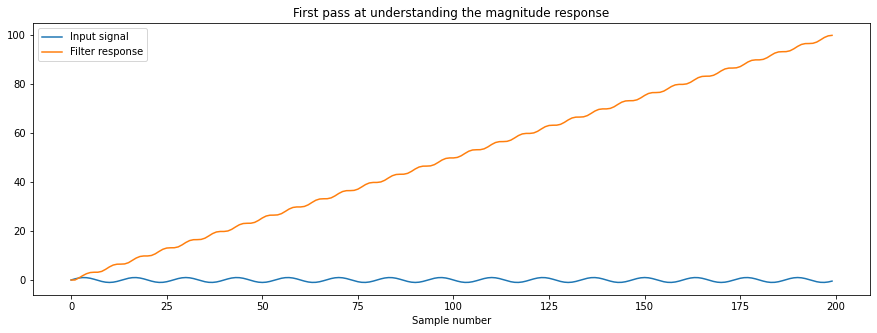

In [13]:
def one_tone_idft_v0():
    '''Our first stab at understanding the magnitude result'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v1(Fs, f_tone, signal)

    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(goertzel_response_base, label='Filter response', color='tab:orange')

    legend()


    xlabel('Sample number')
    title('First pass at understanding the magnitude response')
    
one_tone_idft_v0()

Well, that's a bit awkward.  Note that it grows linearly throughout our full signal.  That smells like an integration.

And, wait: there's a $\frac{1}{N}$ in the DFT equation.  What happens if we add that in?

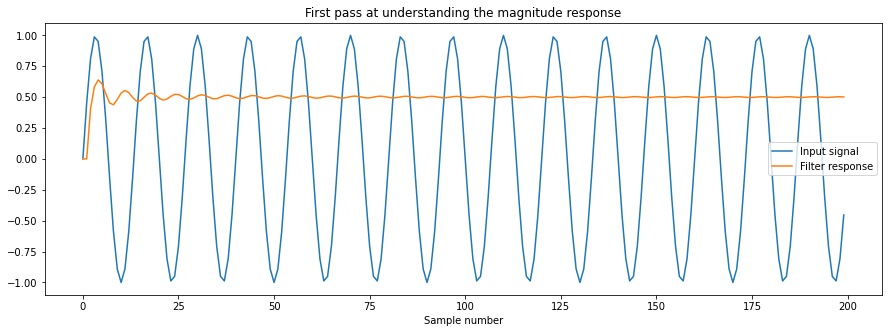

In [14]:
def one_tone_goertzel_v2(Fs: float, f_tone: float, samples: List[int], alpha=1.0) -> List[float]:
    '''Get the *normalized* magnitude of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    alpha: the decay value, which allows filters to die off when they are no longer stimulated
    
    Returns a list of floats, coindexed to the samples, of the magnitude of the
    filter response to the input.  This is the version normalized by N.
    
    In practice, you probably just want to run the z0 loop, and only run the
    res_i,res_q computations periodically.
    
    Also, note that the sqrt is totally unnecessary, but is pedantically correct.
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
    
    result = [0.0] * N  # We'll the magnitude of our results
    
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = alpha*(x + 2*cos_w * z1 - z2) - (1-alpha)*z1
        
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        res_i = z0 * cos_w - z1
        res_q = z0 * sin_w
        
        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        result[i] = res_mag/i
        
        # You can get phase here, too, just look at
        # phase = math.atan2(res_q, res_i)
        # However it's not clear to me how to interpret it
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
    return result

def one_tone_idft_v1():
    '''Our first stab at understanding the magnitude result'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v2(Fs, f_tone, signal)

    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(goertzel_response_base, label='Filter response', color='tab:orange')

    legend()


    xlabel('Sample number')
    title('First pass at understanding the magnitude response')
    
one_tone_idft_v1()

That looks pretty good, actually.  Though it's only coming up to 0.5.  What's up with that?  I'm going to cut it short here, because the theory is confusing.  Suffice it to say, the entries over $N/2$ represent *negative* frequencies, and are only used in properly I/Q (complex number) inputs. Since we work purely in the reals, our magnitude is actually relative to $N/2$.  Let's adjust for that:

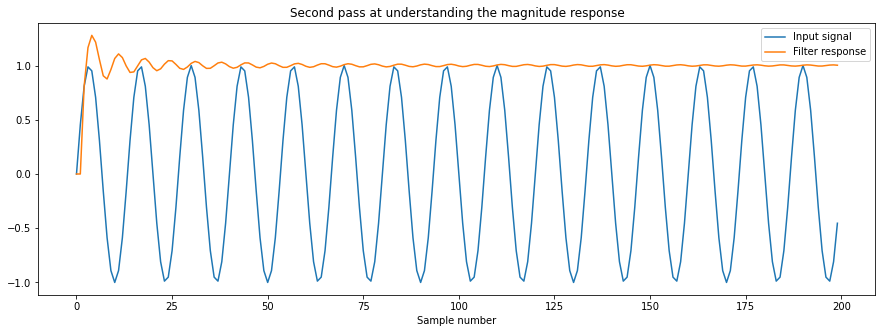

In [15]:
def one_tone_goertzel_v3(Fs: float, f_tone: float, samples: List[int], alpha=1.0) -> List[float]:
    '''Get the *real-normalized* magnitude of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    alpha: the decay value, which allows filters to die off when they are no longer stimulated
    
    Returns a list of floats, coindexed to the samples, of the magnitude of the
    filter response to the input.  This is the version normalized by N/2.
    
    In practice, you probably just want to run the z0 loop, and only run the
    res_i,res_q computations periodically.
    
    Also, note that the sqrt is totally unnecessary, but is pedantically correct.
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
    
    result = [0.0] * N  # We'll the magnitude of our results
    
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = alpha*(x + 2*cos_w * z1 - z2) - (1-alpha)*z1
        
        ##########################
        # Turn that into a complex value, so we can get the 
        # magnitude and output it
        res_i = z0 * cos_w - z1
        res_q = z0 * sin_w
        
        res_mag = math.sqrt(res_i*res_i + res_q*res_q)
        result[i] = res_mag/i*2
        
        # You can get phase here, too, just look at
        # phase = math.atan2(res_q, res_i)
        # However it's not clear to me how to interpret it
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
    return result

def one_tone_idft_v2():
    '''Our first stab at understanding the magnitude result'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)

    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(goertzel_response_base, label='Filter response', color='tab:orange')

    legend()


    xlabel('Sample number')
    title('Second pass at understanding the magnitude response')
    
one_tone_idft_v2()

That looks promising.  What happens if we try to recreate it?

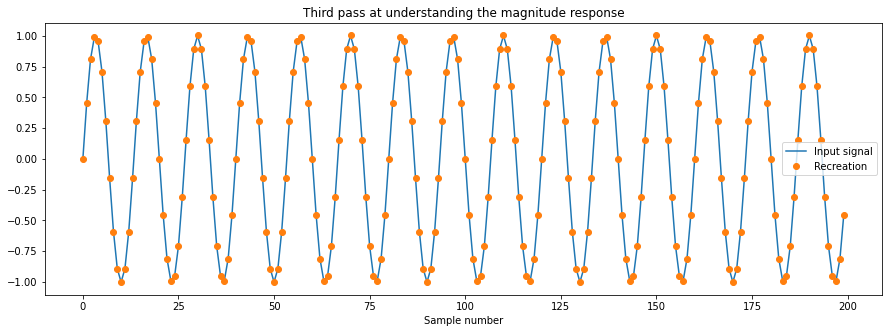

In [16]:
def one_tone_idft_v3():
    '''Our first attempt at applying the magnitude result'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)
    
    mag = goertzel_response_base[-1]
    recreation = [ mag*math.sin(2*math.pi*f_tone/Fs*i) for i in range(N) ]
    
    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(recreation, 'o', label='Recreation', color='tab:orange')


    legend()


    xlabel('Sample number')
    title('Third pass at understanding the magnitude response')
    
one_tone_idft_v3()

So, we have the ability to recreate the waveform, which suggests that we have a good idea of what the magnitude means.  Let's try one more case, to see where we get to.

What happens if the signal is only present in a part of the input buffer?

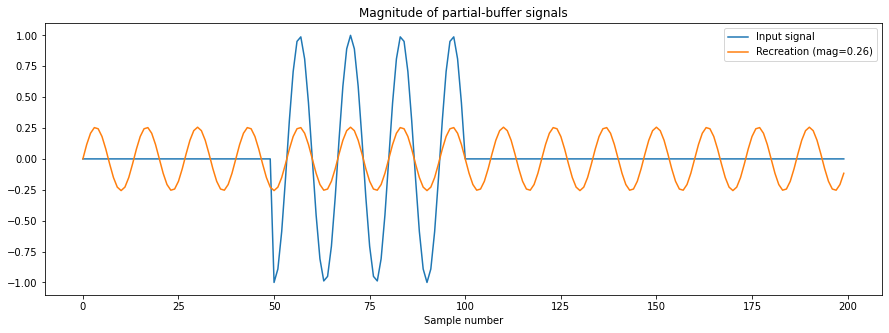

In [17]:
def one_tone_idft_v3_shrunk():
    '''Testing our magnitude result on sub-buffer-length signals'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    theta0 = math.pi/3
    
    for i in range(50,100):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)
    
    mag = goertzel_response_base[-1]
    recreation = [ mag*math.sin(2*math.pi*f_tone/Fs*i) for i in range(N) ]
    
    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(recreation, label=f'Recreation (mag={mag:0.2f})', color='tab:orange')

    legend()

    xlabel('Sample number')
    title('Magnitude of partial-buffer signals')
    
one_tone_idft_v3_shrunk()

As we can see, we filled in about a quarter of the buffer, and the magnitude we got back is about 1/4.  It seems like the magnitude is giving us the amount of the buffer that was filled with our tone.  But, let's change the amplitdue of our signal, and see what happens.

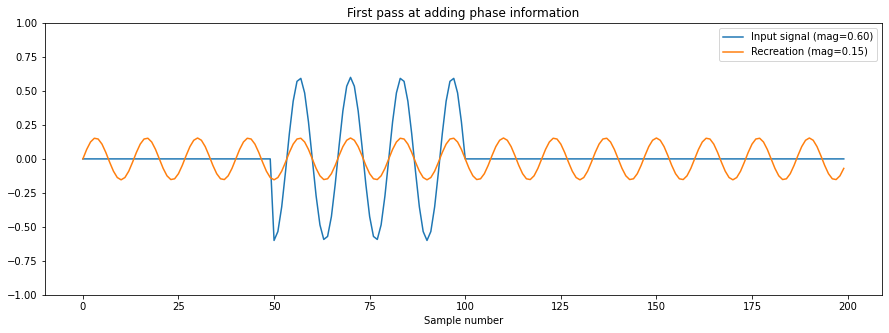

In [18]:
def one_tone_idft_v3_shrunk_shrunk():
    '''Testing our mag/phase result on sub-buffer signals'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    orig_mag = 0.6
    
    theta0 = math.pi/3
    
    for i in range(50,100):
        # Make the whole buffer one tone for now
        signal[i] = orig_mag*math.sin(2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)
    
    mag = goertzel_response_base[-1]
    recreation = [ mag*math.sin(2*math.pi*f_tone/Fs*i) for i in range(N) ]
    
    # Gonna do dual axes for legibility
    plot(signal, label=f'Input signal (mag={orig_mag:0.2f})', color='tab:blue')
    plot(recreation, label=f'Recreation (mag={mag:0.2f})', color='tab:orange')

    legend()
    ylim(-1,1)
    xlabel('Sample number')
    title('First pass at adding phase information')
    
one_tone_idft_v3_shrunk_shrunk()

So, our resultant magnitude is once again a quarter of the input.  That suggests that we're looking at the multiplication of the magnitude with the percent fill, which is helpful.

It is also problematic: we can't tell if a low-magnitude symbol is due to low amplitude or limited extent.  The easiest solution to this for our application will be to use slicing (as we did in the free-running example above), and assume that any symbol that matters will span at a minimum of the slice.

This can also be addressed by specification: if we simply say that any symbol must be as long as two slices, we guarantee always getting at least one full slice for any given symbol.  This removes the duration factor, making magnitude purely about signal strength.

All that remains then is to see how pure noise in our particular bin varies as a function of the noise amplitude.  The theoretical answer is that it should be about $1/\sqrt{N}$, as the energy is split into $N$ bins by the DFT, so the magnitude should be the square root of that.  We can test this empirically, of course.

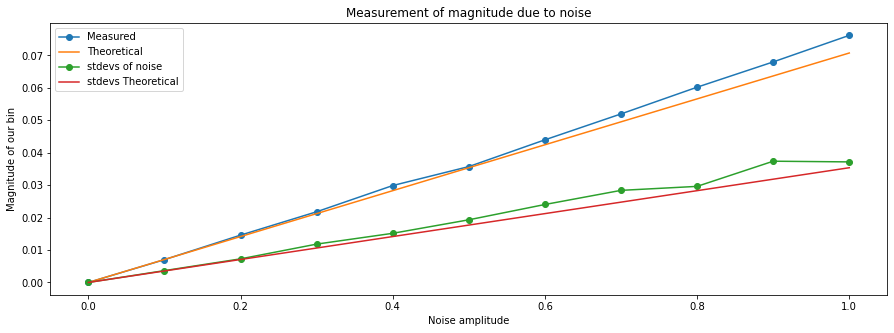

In [19]:
def one_tone_idft_noise_amp_sweep():
    '''Sweep through noise amplitudes, recording the magnitude in our bin'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N
    
    noise_amps = [ i/10 for i in range(11) ]  # Amplitudes of noise
    noise_mags = [0] * len(noise_amps)        # Results at that amplitude
    noise_stds = [0] * len(noise_amps)        # STDs at each ampl

    n_runs = 100 # Run multiple times to get better averages
    
    for i, na in enumerate(noise_amps):
        res = 0.0 
        mags = []
        for _ in range(n_runs):
            for j in range(N):
                signal[j] = na*(2*random.random()-1.0)


            goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)

            mags.append(goertzel_response_base[-1])
            
        mag = sum(mags)/n_runs
        noise_mags[i] = mag
        
        std = math.sqrt(sum([(m - mag)**2 for m in mags])/(n_runs-1))
        noise_stds[i] = std
        
    
    plot(noise_amps, noise_mags, "o-", label="Measured")
    plot(noise_amps, [na/math.sqrt(N) for na in noise_amps], label="Theoretical")
    #plot(noise_amps, [noise_mags[i]+2*noise_stds[i] for i in range(len(noise_amps))], label="2$\sigma$ noise")
    plot(noise_amps, noise_stds, "o-", label="stdevs of noise")
    plot(noise_amps, [na/math.sqrt(N)/2 for na in noise_amps], label="stdevs Theoretical")


    legend()
    xlabel('Noise amplitude')
    ylabel('Magnitude of our bin')
    title('Measurement of magnitude due to noise')
    
one_tone_idft_noise_amp_sweep()

It's so nice when theory comes through for us.  We also added a line of the predicted standard deviation of the noise at each amplitude.  As you can see, it's basically just half the noise.  Therefore, to get the 95% upper bound at a given noise level, just multiply it by two.

This means that a threshold of $2/\sqrt{N}$ is probably a reasonable lower bound.  This means that, with longer slices, you get better noise rejection.  In our case, we can set to 0.2: this means that any full-slice signal that's at least 25% of our amplitude will work out.

This completes everything we need to know to design our filters.  You can stop here, or you can go a little further down the rabbit hole.

## Inverse DFT with phase information

Note that the following section is entirely unrelated to our appliation.  It's included here for completeness, as it's a gotcha that might bite you if you're trying to recreate real world signals with DFTs.

That looks pretty good.  Let's throw a wrench in it, though: what if there is a phase offset in our signal?

If you go back and look at the DFT formula above, actually, here it is again (you're welcome):

$$
x_n = \frac{1}{N}\sum_{i=0}^{N-1}X_i\cdot \exp\left(j 2 \pi \frac{i}{N}n\right)
$$

Note that our actual oscillator is fixed to start at 0

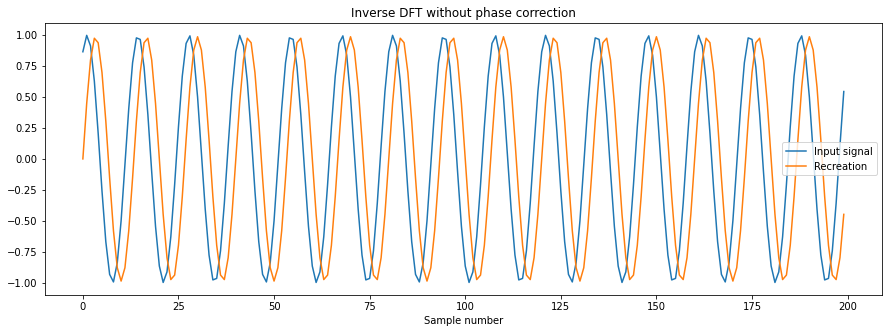

In [20]:
def one_tone_idft_v4():
    '''Adding a phase twist to the DFT results'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    theta0 = math.pi/3
    
    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(theta0 + 2*math.pi*f_tone/Fs*i)
          
    goertzel_response_base = one_tone_goertzel_v3(Fs, f_tone, signal)
    
    mag = goertzel_response_base[-1]
    recreation = [ mag*math.sin(2*math.pi*f_tone/Fs*i) for i in range(N) ]
    
    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(recreation, label='Recreation', color='tab:orange')


    legend()


    xlabel('Sample number')
    title('Inverse DFT without phase correction')
    
one_tone_idft_v4()

That looks close, but disturbingly incorrect.  Only partly because of the weird optical illusion.  We have the ability to get this phase offset, let's see what happens when we try to get apply it.

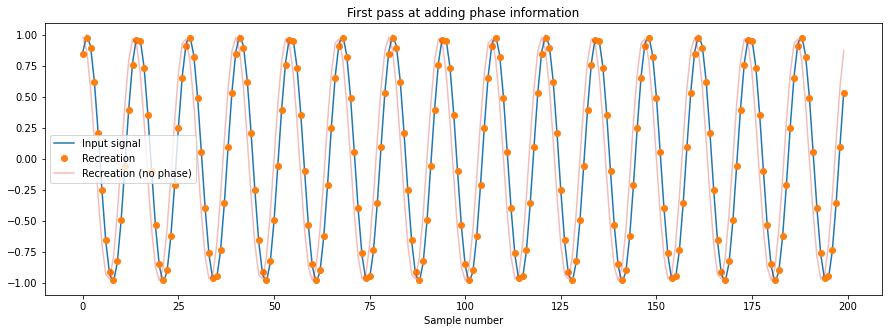

In [21]:
def one_tone_goertzel_v4(Fs: float, f_tone: float, samples: List[int], alpha=1.0) -> List[float]:
    '''Get the *real-normalized* magnitude and phase of our Goertzel filter over a full sample buffer
    
    Fs: the sampling rate
    f_tone: the tone of interest
    samples: a list of sampled values
    alpha: the decay value, which allows filters to die off when they are no longer stimulated
    
    Returns a tuple of (magnitude, phase) for the given DFT coefficient
    
    '''
    # Generate our IIR parameters
    w = 2 * math.pi * f_tone/Fs  # Angular frequency
    cos_w = math.cos(w)  # For the real part
    sin_w = math.sin(w)  # For the complex part
    
    
    z2 = 0  # z^-2: the second to last z value
    z1 = 0  # z^-1: the previous z value
    z0 = None  # z: our current z value
    
    N = len(samples)
        
    ###########################################
    # The actual filter is the next 3 lines of code
    for i in range(2, N):
        x = samples[i]
        
        ##########################
        # Run z-transform
        # Generate our new z value
        z0 = alpha*(x + 2*cos_w * z1 - z2) - (1-alpha)*z1
        
        # And finally rotate our stashed values
        z2 = z1
        z1 = z0
        
    ##########################
    # Get the final complex value
    res_i = z1 * cos_w - z2
    res_q = z1 * sin_w

    res_mag = math.sqrt(res_i*res_i + res_q*res_q)/N*2
    phase = math.atan2(res_q, res_i)
   
    return (res_mag, phase)


def one_tone_idft_v5():
    '''Our first attempt at applying the phase result'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    theta0 = math.pi/3
    
    for i in range(N):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(theta0 + 2*math.pi*f_tone/Fs*i)
          
    mag, phase = one_tone_goertzel_v4(Fs, f_tone, signal)
    
    # Note that e^(j theta) expands its real part to cos(), not to sin()!
    recreation = [ mag*math.cos(phase+2*math.pi*f_tone/Fs*i) for i in range(N) ]
    recreation_no_phase = [ mag*math.cos(2*math.pi*f_tone/Fs*i) for i in range(N) ]

    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(recreation, 'o', label='Recreation', color='tab:orange')
    plot(recreation_no_phase, label='Recreation (no phase)', color='tab:red', alpha=0.3)

    legend()

    xlabel('Sample number')
    title('First pass at adding phase information')
    
one_tone_idft_v5()

Now, let's try one more thing: what about signals that start and stop?

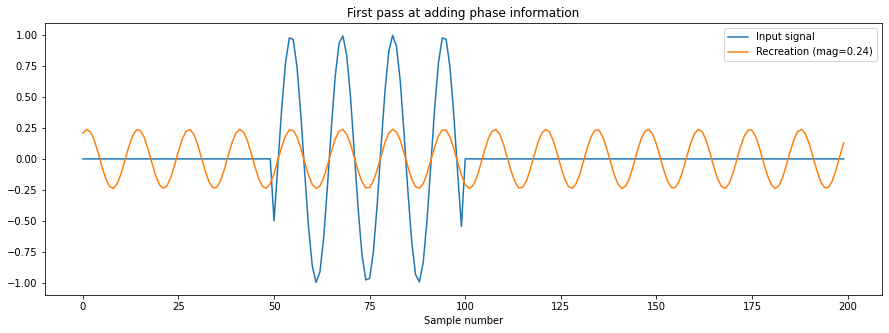

In [22]:
def one_tone_idft_v6():
    '''Testing our mag/phase result on sub-buffer signals'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    theta0 = math.pi/3
    
    for i in range(50,100):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(theta0 + 2*math.pi*f_tone/Fs*i)
          
    mag,phase = one_tone_goertzel_v4(Fs, f_tone, signal)
    
    recreation = [ mag*math.cos(phase+2*math.pi*f_tone/Fs*i) for i in range(N) ]

    # Gonna do dual axes for legibility
    plot(signal, label='Input signal', color='tab:blue')
    plot(recreation, label=f'Recreation (mag={mag:0.2f})', color='tab:orange')

    legend()

    xlabel('Sample number')
    title('First pass at adding phase information')
    
one_tone_idft_v6()

The phase looks correct, so there's that.  But the magnitude is tiny, just as before.

What if we split it up into slices, and recreate things piecewise?

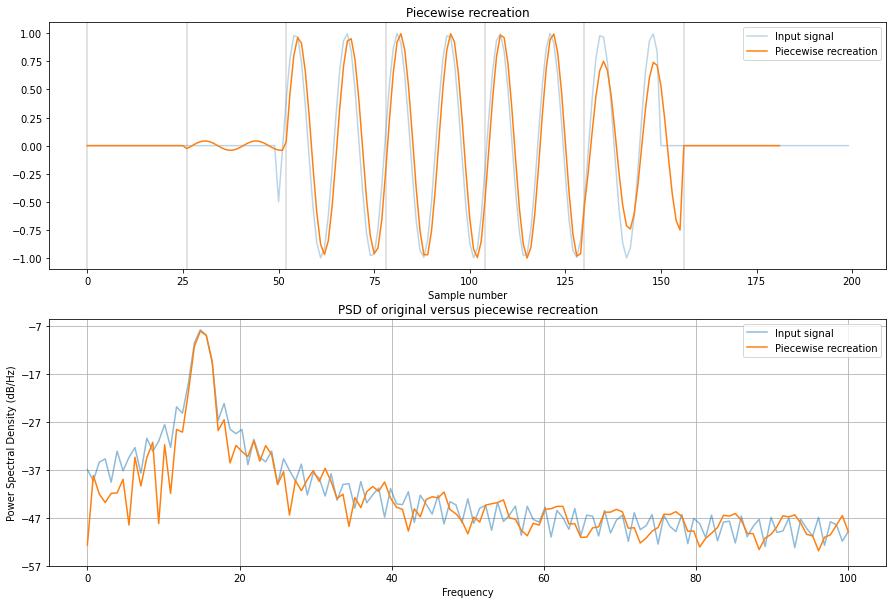

In [23]:
def one_tone_idft_v7():
    '''Testing our mag/phase result on buffer slices'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N

    theta0 = math.pi/3
    
    for i in range(50,150):
        # Make the whole buffer one tone for now
        signal[i] = math.sin(theta0 + 2*math.pi*f_tone/Fs*i)
          
    
    buf_slice = int(Fs/f_tone*2) # try to fit multiple cycles in
    
    
    figure(figsize=(15,10))
    subplot(2,1,1) # We do axvlines on the first plot while recreating
    recreation = []
    for j in range(0,int(N/buf_slice)):
        i = buf_slice * j
        axvline(i, color='grey', alpha=0.3)
        mag,phase = one_tone_goertzel_v4(Fs, f_tone, signal[i:i+buf_slice])
        
        rec_slice = [ mag*math.cos(phase+2*math.pi*f_tone/Fs*i) for i in range(buf_slice) ]
        recreation.extend(rec_slice)
    

    # Gonna do dual axes for legibility
    plot(signal, alpha=0.3, label='Input signal', color='tab:blue')
    plot(recreation, label=f'Piecewise recreation', color='tab:orange')

    legend()

    xlabel('Sample number')
    title('Piecewise recreation')
    
    subplot(2,1,2)
    psd(signal, Fs=Fs, alpha=0.5, label='Input signal')
    psd(recreation, Fs=Fs, label='Piecewise recreation')
    legend()
    title('PSD of original versus piecewise recreation')
    
one_tone_idft_v7()

That looks pretty good, actually.  There is a problem at the head and tail of the signal, but that's down to the temporal resolution of our slices.  There is definitely some harmonic noise in the PSD, but it looks usable.  What if we noise up the input?

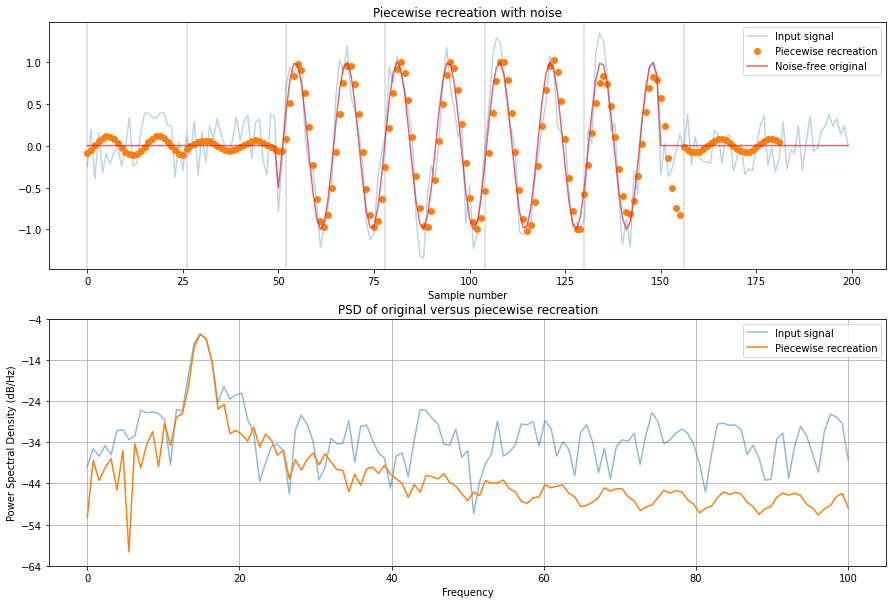

In [24]:
def one_tone_idft_v8():
    '''Testing our mag/phase result on buffer slices'''
    Fs = 200
    f_tone = 15
    
    N = 200
    
    signal = [0] * N
    signal_clean = [0] * N

    theta0 = math.pi/3
    
    for i in range(N):
        signal[i] = 0.4*(2.0*random.random()-1)
    for i in range(50,150):
        # Make the whole buffer one tone for now
        signal[i] += math.sin(theta0 + 2*math.pi*f_tone/Fs*i)          
        signal_clean[i] = math.sin(theta0 + 2*math.pi*f_tone/Fs*i)          

    buf_slice = int(Fs/f_tone*2) # try to fit multiple cycles in
    
    
    figure(figsize=(15,10))
    subplot(2,1,1) # We do axvlines on the first plot while recreating
    recreation = []
    for j in range(0,int(N/buf_slice)):
        i = buf_slice * j
        axvline(i, color='grey', alpha=0.3)
        mag,phase = one_tone_goertzel_v4(Fs, f_tone, signal[i:i+buf_slice])
        
        rec_slice = [ mag*math.cos(phase+2*math.pi*f_tone/Fs*i) for i in range(buf_slice) ]
        recreation.extend(rec_slice)
    

    # Gonna do dual axes for legibility
    plot(signal, alpha=0.3, label='Input signal', color='tab:blue')
    plot(recreation, 'o', label=f'Piecewise recreation', color='tab:orange')
    plot(signal_clean, alpha=0.7, label=f'Noise-free original', color='tab:red')

    legend()

    xlabel('Sample number')
    title('Piecewise recreation with noise')
    
    subplot(2,1,2)
    psd(signal, Fs=Fs, alpha=0.5, label='Input signal')
    psd(recreation, Fs=Fs, label='Piecewise recreation')
    legend()
    title('PSD of original versus piecewise recreation')
    
one_tone_idft_v8()

Even with the noise, it does pretty well.  Also, note that the recreation lowers the noise floor, as all the other stuff gets throw away in our processing.  A nice result overall.

So, at this point, we have a very complete handle on using this IIR as a tool for getting a single-bin DFT.

In additiont to that, we have the bones for a good DTMF decoder.  We will use this code to make some unit tests, and then we're good to go.

### Appendix: dump a sample file for unit testing of C code

We want to implement this in C, and we have a nice unit testing framework (that runs on Linux, not on the micro).  It makes sense to export one of these buffers to be used in that testing.

In [41]:
def dump_unit_test_buffer():
    '''We want a C file that contains a useful waveform for testing.  This makes that'''
    
    # Stash the old random seed before we force it into determinism
    old_state = random.getstate()
    
    # Set state to make this deterministic
    random.seed(42)
    
    Fs = 8000
    digit_dur = 0.045  # DTMF maximum rate is 45ms/10ms
    gap_dur = 0.020

    s = '147*2580369#ABCD'

    tones = DTMFGen.dial(Fs, digit_dur, gap_dur, s)
    
    # Add some noise to mask gaps, tweak the coefficient and see how it changes
    tones += 2*np.random.uniform(-0.1, 0.1, len(tones))

    # And turn it into uint8s, note the limited gain
    tones = (127 + 64*tones).astype(np.uint8)
    
    f = open("../src/tests/fixture_dtmf_tones.c", "w")
    
    f.write(f'''
// NOTE: This file was generated from code/notebooks/dtmf_filter_design.ipynb
// Search for beepboop to get to the codegen quickly.

// Please be aware that this generation is deterministic, and the unit tests may
// rely on that somewhat.  Just run all the tests any time you mangle it, and
// anticipate fixing up a bit of laziness about symbol lengths etc in some of the
// tests for corner cases.

#define FIXTURE_DTMF_FS {Fs:0.1f} //!< Sampling rate of our test buffer
#define FIXTURE_DTMF_BUFLEN {len(tones)} //!< length of sample buffer, in samples

const uint8_t fixture_dtmf_symbols[] = "{s}"; //!< The expected decode

/**
* Our test waveform, to be decoded
*/
const uint8_t fixture_dtmf_buffer[FIXTURE_DTMF_BUFLEN] = {{
''')
    
    for i in range(0, len(tones), 16):
            f.write('  ')
            f.write(" ".join([f'{x:3d},' for x in tones[i:i+16]]))
            f.write('\n')
    
    f.write('};')
    
    f.close()
    
    # Restore the random generator to its old, actually-random state    
    random.setstate(old_state)

dump_unit_test_buffer()